In [ ]:
# --- 1. SETUP & IMPORTS ---
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Automatické přenačítání modulů při změně
%load_ext autoreload
%autoreload 2

# Přidání složky 'src' do cesty Pythonu
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import našich modulů
from config import *
import load_preprocess_data as loader
import visualization as viz

# Nastavení vizuálního stylu (barvy, fonty)
viz.setup_style()

print(f"✅ Notebook připraven.")
print(f"   - Data Directory: {DATA_DIR}")
print(f"   - Vectors Directory: {VECTORS_DIR}")

⚙️ Konfigurace načtena. Používám zařízení: cpu
🎨 Vizualizační styl nastaven: whitegrid
✅ Notebook připraven.
   - Data Directory: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data
   - Vectors Directory: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\vectors


# Příprava Dat a EDA (Exploratory Data Analysis)

Tento notebook slouží jako vstupní bod celého projektu.

**Cíle:**
1.  **Preprocessing:** Načíst surová data (JSONL), prohnat je přes NLP pipeline (RobeCzech + spaCy) a uložit "Interim" verzi.
2.  **Vektorizace:** Vygenerovat trénovací artefakty (`.pkl` soubory) pro různé konfigurace filtrů a poolingů.
3.  **EDA:** Prozkoumat statistiky datasetů (vyváženost tříd, délky vět, morfologie anomálií).

---

### ZPRACOVÁNÍ GOLD DATASETU

In [2]:
# --- A. ZPRACOVÁNÍ GOLD DATASETU (Malý, Čistý) ---
print("--- ZPRACOVÁNÍ GOLD DATASETU ---")

# Cesta k interim souboru (mezikrok s embeddingy)
gold_interim_path = DATA_DIR / 'interim' / 'GOLD_data_processed.jsonl'
gold_interim_path.parent.mkdir(parents=True, exist_ok=True)

# 1. NLP Pipeline (Text -> Embeddings)
# Pokud soubor neexistuje, vytvoříme ho.
if not os.path.exists(gold_interim_path):
    print("Generuji Interim soubor (BERT + spaCy)...")
    df_gold = loader.create_interim_jsonl(
        input_path=PATH_GOLD_RAW,
        output_path=gold_interim_path
    )
else:
    print("✅ Interim soubor již existuje, načítám z disku...")
    df_gold = pd.read_json(gold_interim_path, lines=True)

# 2. Generování Artefaktů (.pkl vektorů)
# Toto rozseká data na malé soubory pro experimenty (Mild/Agg/None)
loader.generate_vector_artifacts(
    interim_path=gold_interim_path,
    dataset_name='gold'
)

--- ZPRACOVÁNÍ GOLD DATASETU ---
✅ Interim soubor již existuje, načítám z disku...

🔨 Generuji vektorové artefakty pro: GOLD
   -> Processing 520 lines stream-wise...


Extracting Vectors: 100%|██████████| 520/520 [00:04<00:00, 118.31it/s]


💾 Saving artifacts to C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\vectors\gold...
✅ Artifacts saved successfully.


### ZPRACOVÁNÍ SILVER DATASETU

In [3]:
# --- B. ZPRACOVÁNÍ SILVER DATASETU ---
print("\n--- ZPRACOVÁNÍ SILVER DATASETU ---")

silver_interim_path = DATA_DIR / 'interim' / 'SILVER_data_processed.jsonl'

# 1. NLP Pipeline
if not os.path.exists(silver_interim_path):
    print("Generuji Interim soubor pro Silver (může trvat dlouho)...")
    df_silver = loader.create_interim_jsonl(
        input_path=PATH_SILVER_RAW,
        output_path=silver_interim_path
    )
else:
    print("✅ Interim soubor již existuje, načítám z disku...")
    try:
            df_silver = pd.read_json(silver_interim_path, lines=True, nrows=20000)
            print(f"✅ Načteno {len(df_silver)} řádků ze Silver datasetu.")
    except Exception as e:
            print(f"❌ Chyba při načítání Silver: {e}")
            df_silver = None

# 2. Generování Artefaktů
# Vytvoří .pkl soubory (pouze vektory), které jsou malé a rychlé
loader.generate_vector_artifacts(
    interim_path=silver_interim_path,
    dataset_name='silver'
)


--- ZPRACOVÁNÍ SILVER DATASETU ---
✅ Interim soubor již existuje, načítám z disku...
✅ Načteno 1903 řádků ze Silver datasetu.

🔨 Generuji vektorové artefakty pro: SILVER
   -> Processing 1903 lines stream-wise...


Extracting Vectors: 100%|██████████| 1903/1903 [00:34<00:00, 55.90it/s] 


💾 Saving artifacts to C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\vectors\silver...
✅ Artifacts saved successfully.


# Exploratory Data Analysis (EDA)


In [4]:
# --- C. DEFINICE EDA FUNKCÍ (Helper Functions) ---

def prepare_eda_features(df):
    """
    Přidá do DataFrame sloupce potřebné pro EDA (délky, pozice, POS).
    Vrací upravený DataFrame.
    """
    df = df.copy()
    
    # 1. Výpočet délek (počet slov oddělených mezerou)
    def count_tokens_simple(text):
        if pd.isna(text) or not isinstance(text, str): return 0
        return len(text.split())

    df['target_len'] = df['target_sentence'].apply(count_tokens_simple)
    df['total_len'] = df['target_len'] + df['context_prev'].apply(count_tokens_simple) + df['context_next'].apply(count_tokens_simple)
    
    # 2. Extrakce POS Tagu a Pozice pro Target Token
    # (Pouze pokud máme sloupec 'tokens' z preprocessingu)
    def analyze_token_info(row):
        if row['label'] == 0: return None, None # U neutrálních nás to tolik nezajímá (nebo nemají target)
        
        target_form = row.get('target_token')
        if not target_form: return None, None
        
        # Hledání v tokenech
        found_pos = None
        found_idx = -1
        
        # A) Zkusíme najít v 'tokens' (přesnější - z spaCy)
        if 'tokens' in row and isinstance(row['tokens'], list):
            for i, t in enumerate(row['tokens']):
                if t['form'] == target_form and t['sent_id'] == 1:
                    found_pos = t['pos']
                    # Pro index musíme spočítat kolikátý je to token v rámci věty 1
                    # Zjednodušení: vezmeme index z tokens listu, který odpovídá target větě
                    break
        
        # B) Fallback pro pozici: Hledání v textu (pro graf pozice)
        try:
            words = row['target_sentence'].split()
            found_idx = words.index(target_form)
        except:
            found_idx = -1
            
        return found_pos, found_idx

    # Aplikace (vrací tuple, rozdělíme do sloupců)
    # Používáme zip(*...) pro rozbalení tuplů
    try:
        df['target_pos'], df['target_idx'] = zip(*df.apply(analyze_token_info, axis=1))
        
        # Relativní pozice (0.0 = začátek, 1.0 = konec)
        df['relative_pos'] = df['target_idx'] / df['target_len']
        # Bucketizace po 10%
        df['pos_bucket'] = pd.cut(df['relative_pos'], bins=np.arange(0, 1.1, 0.1), right=True)
    except Exception as e:
        print(f"⚠️ Warning: Nepodařilo se extrahovat detailní token info: {e}")

    return df

def run_full_eda(df, dataset_name):
    """
    Spustí kompletní sadu grafů a statistik pro daný dataset.
    """
    print(f"\n{'='*40}")
    print(f"📊 EDA REPORT: {dataset_name.upper()} DATASET")
    print(f"{'='*40}")
    
    if df is None or len(df) == 0:
        print("❌ Dataset je prázdný.")
        return

    # Příprava dat
    df_eda = prepare_eda_features(df)
    
    # --- 1. ZÁKLADNÍ STATISTIKY ---
    print(f"\n--- 1. Základní přehled ({dataset_name}) ---")
    print(f"Celkem řádků: {len(df_eda)}")
    print("\nRozdělení Labelů:")
    print(df_eda['label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    
    if 'source' in df_eda.columns:
        print("\nRozdělení dle Zdroje:")
        print(pd.crosstab(df_eda['source'], df_eda['label']))

    # --- 2. GRAF: DÉLKA VĚT ---
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df_eda, x='target_len', hue='label', 
        kde=True, bins=range(0, 40), element="step",
        palette=[COLORS['l0'], COLORS['l1']]
    )
    plt.title(f'{dataset_name}: Rozložení délky cílových vět', fontsize=14)
    plt.xlabel('Počet tokenů')
    plt.axvline(df_eda['target_len'].mean(), color='black', linestyle='--', label=f'Průměr: {df_eda["target_len"].mean():.1f}')
    plt.legend()
    plt.show()

    # --- FILTR PRO ANOMÁLIE (L1) ---
    df_l1 = df_eda[df_eda['label'] == 1]
    if len(df_l1) == 0:
        print("⚠️ Žádné anomálie k analýze.")
        return

    # --- 3. GRAF: NEJČASTĚJŠÍ LJMPNIK TOKENY ---
    top_n = 15
    top_tokens = df_l1['target_token'].value_counts().head(top_n)
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_tokens.index, y=top_tokens.values, palette="rocket")
    plt.title(f'{dataset_name}: Top {top_n} nejčastějších anomálií (L1)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # --- 4. GRAF: POZICE VE VĚTĚ ---
    if 'pos_bucket' in df_l1.columns:
        pos_counts = df_l1['pos_bucket'].value_counts().sort_index()
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=pos_counts.index.astype(str), y=pos_counts.values, palette="viridis")
        plt.title(f'{dataset_name}: Kde se anomálie nachází? (0.0=Začátek, 1.0=Konec)', fontsize=14)
        plt.xlabel('Relativní pozice')
        plt.xticks(rotation=45)
        plt.show()

    # --- 5. GRAF: POS TAGY (Slovní druhy) ---
    if 'target_pos' in df_l1.columns:
        pos_counts = df_l1['target_pos'].value_counts()
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=pos_counts.index, y=pos_counts.values, palette="mako")
        plt.title(f'{dataset_name}: Slovní druhy (POS) anomálií', fontsize=14)
        plt.xlabel('POS Tag')
        plt.show()


📊 EDA REPORT: GOLD DATASET

--- 1. Základní přehled (GOLD) ---
Celkem řádků: 520

Rozdělení Labelů:
label
1    63.85%
0    36.15%
Name: proportion, dtype: object

Rozdělení dle Zdroje:
label     0    1
source          
Author   38  126
LLM     137  160
Real     13   46


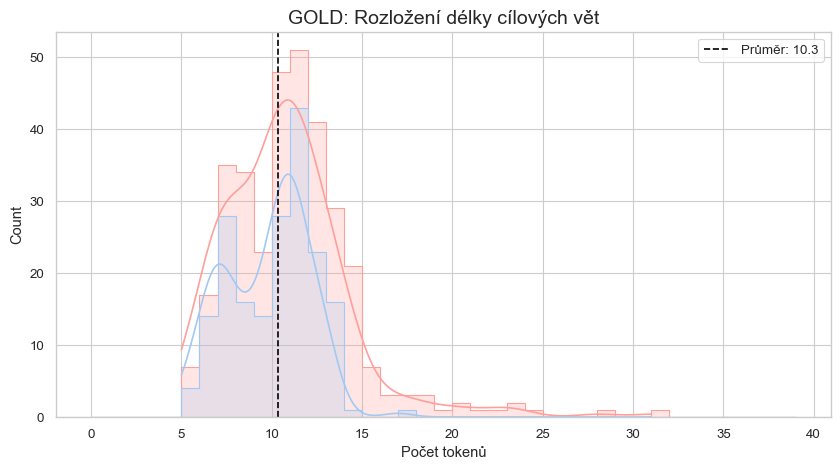

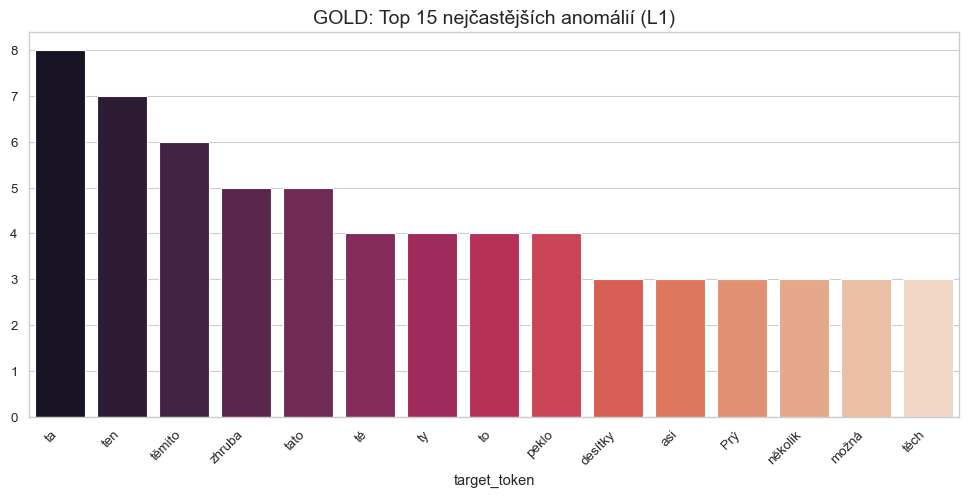

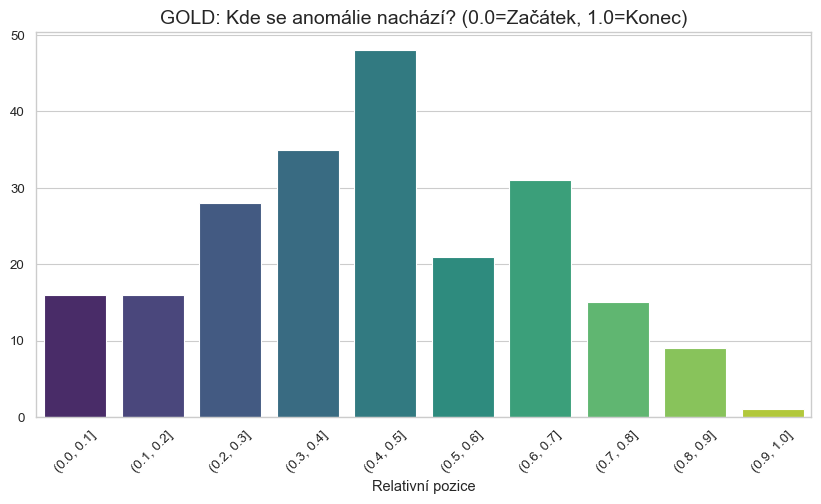

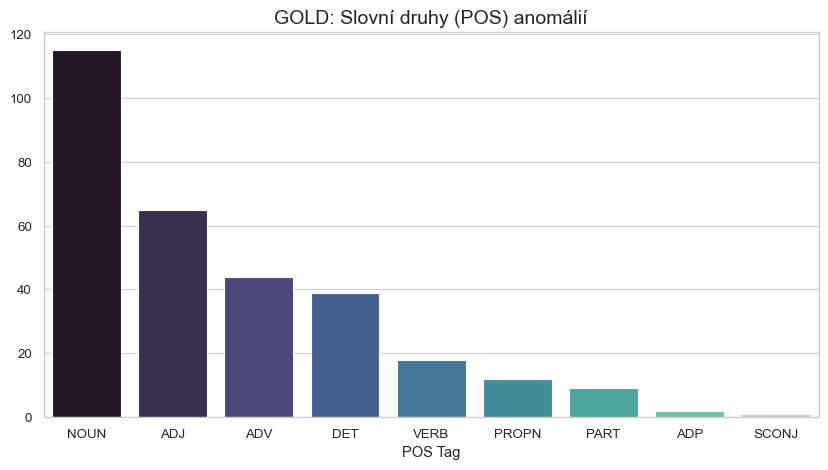

In [5]:
# --- D. EDA: GOLD DATASET ---
if 'df_gold' in locals():
    run_full_eda(df_gold, "GOLD")
else:
    print("⚠️ Dataset GOLD není načten.")


📊 EDA REPORT: SILVER DATASET

--- 1. Základní přehled (SILVER) ---
Celkem řádků: 1903

Rozdělení Labelů:
label
1    50.03%
0    49.97%
Name: proportion, dtype: object

Rozdělení dle Zdroje:
label      0    1
source           
LLM_Gen  951  952


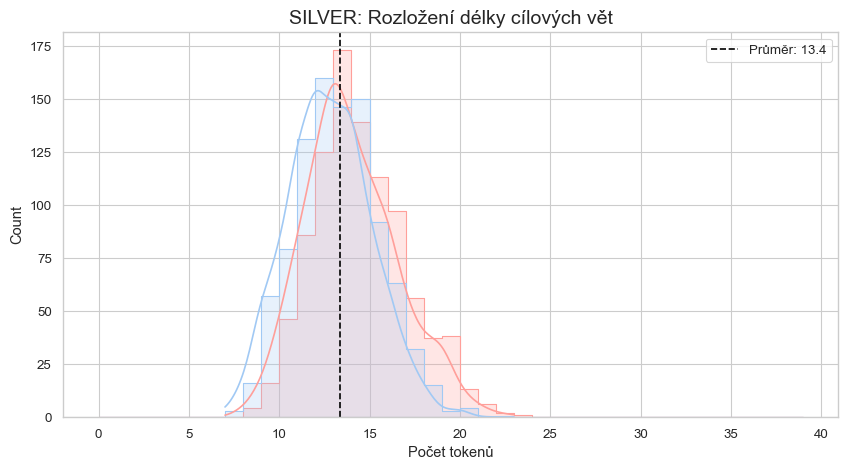

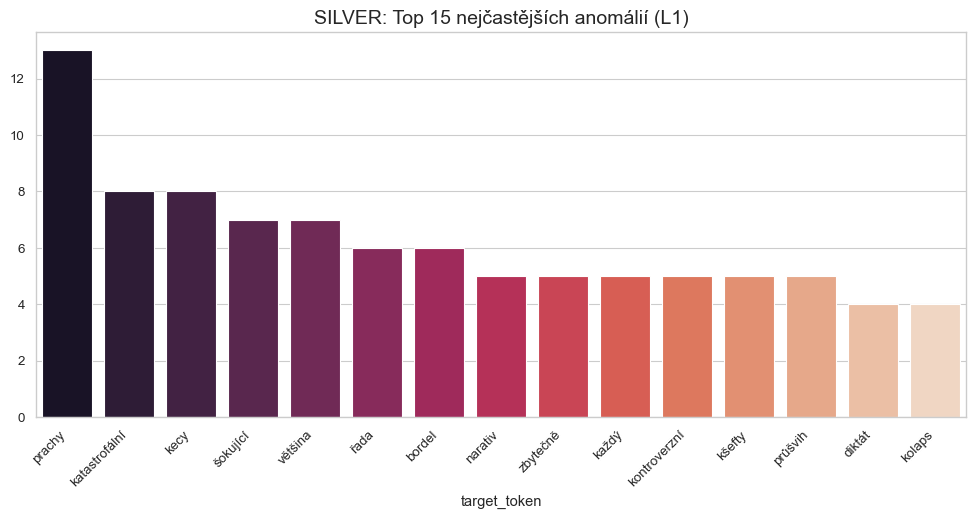

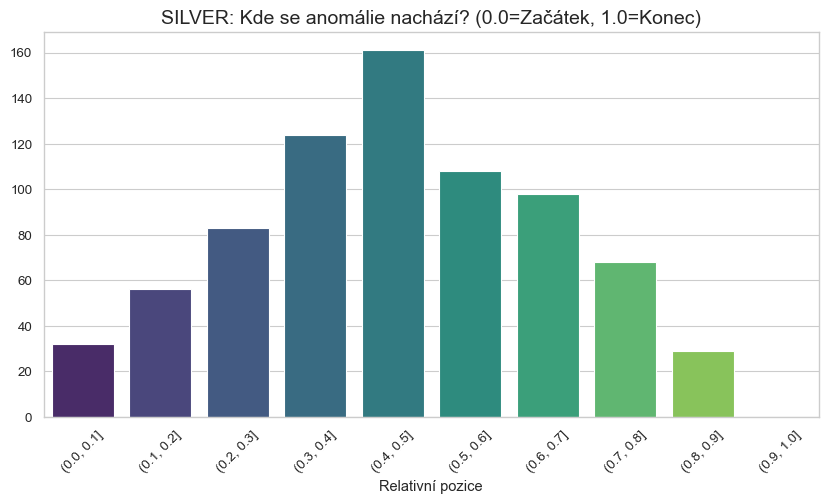

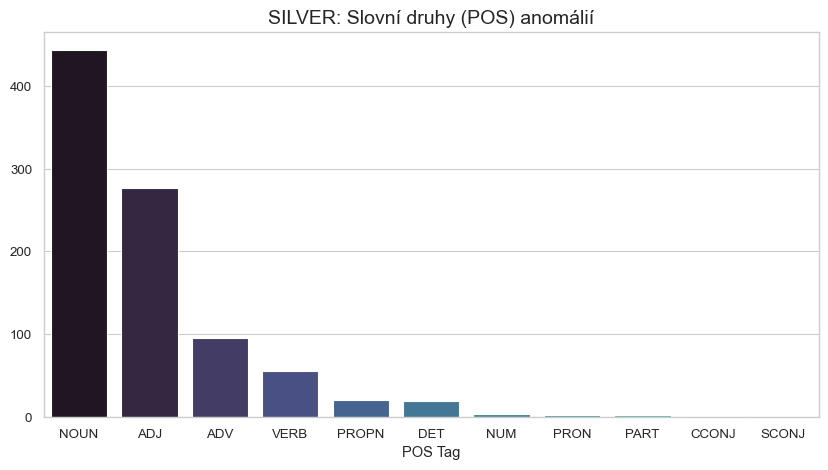

In [6]:
# --- D. EDA: SILVER DATASET ---
if 'df_silver' in locals():
    run_full_eda(df_silver, "SILVER")
else:
    print("⚠️ Dataset SILVER není načten.")

### Shrnutí
Data jsou úspěšně předzpracována.
- Máme vytvořené **Interim soubory** (JSONL s embeddingy) pro EDA.
- Máme vygenerované **Vector Artefakty** (.pkl) ve složce `data/vectors/` připravené pro trénink.
- Z EDA vidíme rozložení tříd a morfologickou strukturu anomálií.

**Další krok:** Otevřít notebook `02_M1_Unsupervised_Detection.ipynb` a spustit první experimenty.